# Segment the bank churn dataset using GOWER similarity and DBScan Clustering

In [1]:
# Data Visualization:
# DB Scan: 
#   https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
# Clustering categorical and numeric datset:
# https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad
# Clustering Categorical Data Visualization
#   https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0
# Explain Clustering Results with Shapley Values:
#   https://towardsdatascience.com/how-to-make-clustering-explainable-1582390476cc 
#   https://medium.com/bricklane-tech/a-new-approach-to-clustering-interpretation-7729cb665ee8
# Understand tSNE:
#   https://www.youtube.com/watch?v=43ySR7_Yb4E
# General Visualization Strategies for high dim data:
#   https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

In [2]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cluster Explainability
import shap

# Import Data
the dataset is available here: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

- CustomerId—contains random values and has no effect on customer leaving the bank.
- Surname—the surname of a customer has no impact on their decision to leave the bank.
- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank.
- Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
-Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- NumOfProducts—refers to the number of products that a customer has purchased through the bank.
- HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- IsActiveMember—active customers are less likely to leave the bank.
- EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- Churn—whether or not the customer left the bank.

In [3]:
# load the local dataset 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank_customers_churn_dataset.csv',
        index_col='customer_id'
)

# drop churn column for segmentation
df.drop('churn', axis=1, inplace=True)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [4]:
# change type of categorical columns "credit_card" and "active_member"
df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,yes,yes,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58
15619304,502,France,Female,42,8,159660.80,3,yes,no,113931.57
15701354,699,France,Female,39,1,0.00,2,no,no,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10


In [5]:
# check unique values for categorical values
print(df['country'].unique())
print(df['gender'].unique())
print(df['credit_card'].unique())
print(df['active_member'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']
['yes' 'no']
['yes' 'no']


# Train-Test Split the Data

In [6]:
df.shape

(10000, 10)

In [7]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.3, random_state=123)

In [8]:
X_train.shape

(7000, 10)

In [9]:
X_test.shape

(3000, 10)

In [10]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15638003,648,Spain,Male,55,1,81370.07,1,no,yes,181534.04
15808971,693,Spain,Female,57,9,0.00,2,yes,yes,135502.77
15800482,586,Spain,Female,33,7,0.00,2,yes,yes,168261.40
15746726,438,Germany,Male,31,8,78398.69,1,yes,no,44937.01
15750407,768,Germany,Female,43,2,129264.05,2,no,no,19150.14


# Exploratory Data Analysis

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 15638003 to 15588461
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      7000 non-null   int64  
 1   country           7000 non-null   object 
 2   gender            7000 non-null   object 
 3   age               7000 non-null   int64  
 4   tenure            7000 non-null   int64  
 5   balance           7000 non-null   float64
 6   products_number   7000 non-null   int64  
 7   credit_card       7000 non-null   object 
 8   active_member     7000 non-null   object 
 9   estimated_salary  7000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 601.6+ KB


In [12]:
X_train.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
dtype: int64

## Impute Missing Values

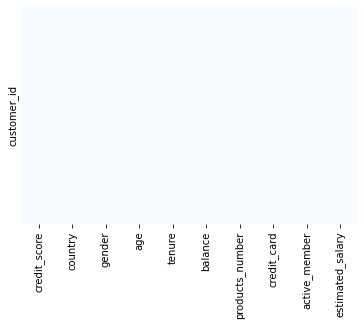

In [13]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [14]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [15]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'estimated_salary']

In [16]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['country', 'gender', 'credit_card', 'active_member']

In [17]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15638003,648.0,55.0,1.0,81370.07,1.0,181534.04
15808971,693.0,57.0,9.0,0.00,2.0,135502.77
15800482,586.0,33.0,7.0,0.00,2.0,168261.40
15746726,438.0,31.0,8.0,78398.69,1.0,44937.01
15750407,768.0,43.0,2.0,129264.05,2.0,19150.14


In [18]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15638003,Spain,Male,no,yes
15808971,Spain,Female,yes,yes
15800482,Spain,Female,yes,yes
15746726,Germany,Male,yes,no
15750407,Germany,Female,no,no


In [19]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [20]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15638003,648.0,55.0,1.0,81370.07,1.0,181534.04,Spain,Male,no,yes
15808971,693.0,57.0,9.0,0.00,2.0,135502.77,Spain,Female,yes,yes
15800482,586.0,33.0,7.0,0.00,2.0,168261.40,Spain,Female,yes,yes
15746726,438.0,31.0,8.0,78398.69,1.0,44937.01,Germany,Male,yes,no
15750407,768.0,43.0,2.0,129264.05,2.0,19150.14,Germany,Female,no,no


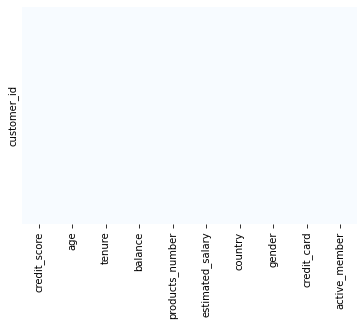

In [21]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [22]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category country: 
France     3512
Spain      1745
Germany    1743
Name: country, dtype: int64
Value counts in category gender: 
Male      3833
Female    3167
Name: gender, dtype: int64
Value counts in category credit_card: 
yes    4938
no     2062
Name: credit_card, dtype: int64
Value counts in category active_member: 
yes    3607
no     3393
Name: active_member, dtype: int64


## Encode Rare Labels

In [23]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable country is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable credit_card is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable active_member is less than that indicated in n_categories. Thus, all categories will be considered frequent


,country,gender,credit_card,active_member
customer_id,,,,
15638003,Spain,Male,no,yes
15808971,Spain,Female,yes,yes
15800482,Spain,Female,yes,yes
15746726,Germany,Male,yes,no
15750407,Germany,Female,no,no


In [24]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Visualize Numerical Features

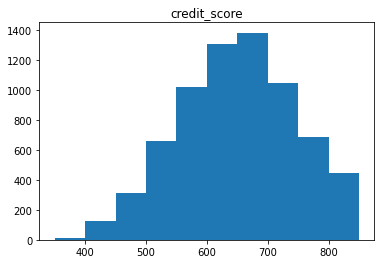

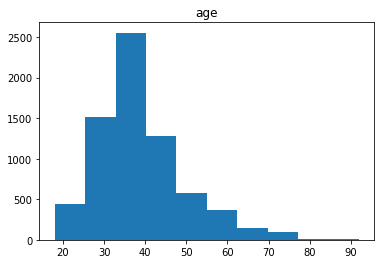

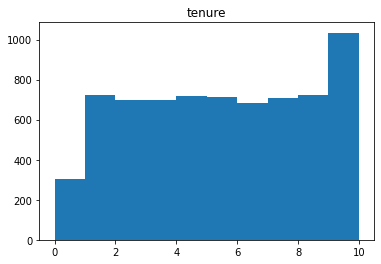

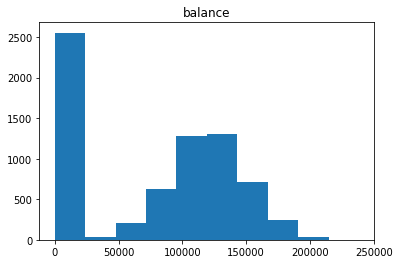

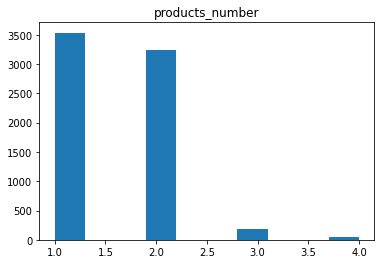

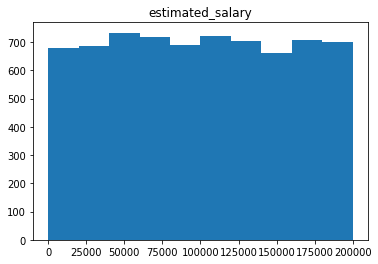

In [25]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [26]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [27]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15638003,648.0,55.0,1.0,81370.07,1.0,181534.04,Spain,Male,no,yes
15808971,693.0,57.0,9.0,0.00,2.0,135502.77,Spain,Female,yes,yes
15800482,586.0,33.0,7.0,0.00,2.0,168261.40,Spain,Female,yes,yes
15746726,438.0,31.0,8.0,78398.69,1.0,44937.01,Germany,Male,yes,no
15750407,768.0,43.0,2.0,129264.05,2.0,19150.14,Germany,Female,no,no


In [28]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

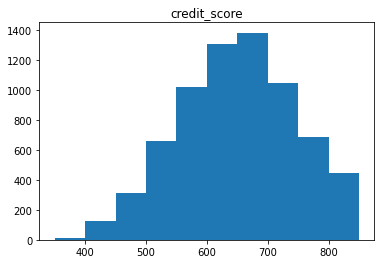

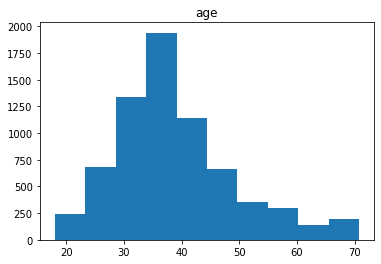

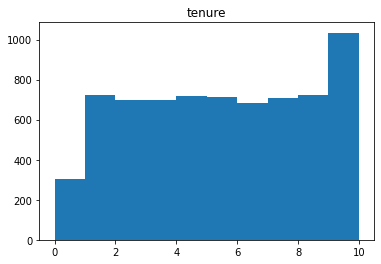

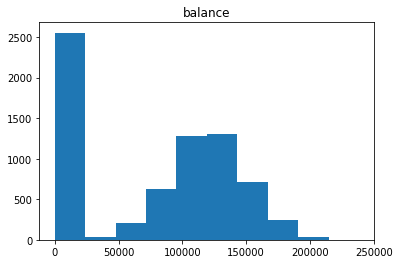

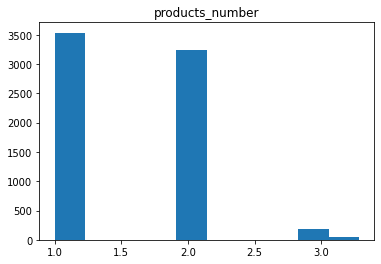

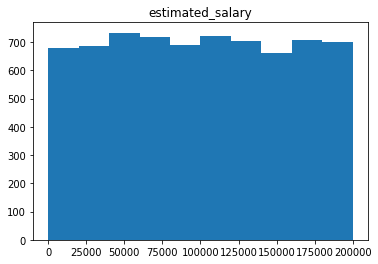

In [29]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Calculate Customer Similarity using Gower´s Distance

In [30]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 32.8 s
Wall time: 32.8 s


In [31]:
distance_matrix.shape

(7000, 7000)

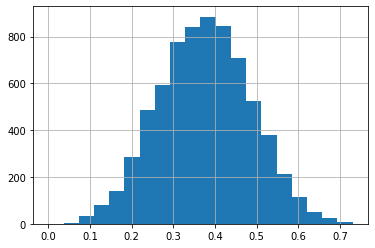

In [32]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [33]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.2  

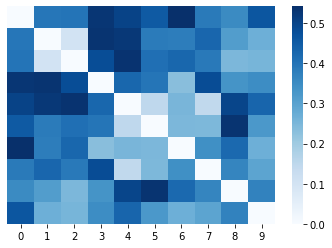

In [34]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [35]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([ 100, 4151, 5107, 2888, 4103], dtype=int64),
 'values': array([0.        , 0.01547415, 0.03082183, 0.03845113, 0.03979811],
       dtype=float32)}

In [36]:
top_n['index']

array([ 100, 4151, 5107, 2888, 4103], dtype=int64)

In [37]:
X_train.iloc[top_n['index'],:]

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15776605,528.0,36.0,7.0,0.0,2.0,60536.56,Spain,Male,yes,no
15638068,507.0,32.0,7.0,0.0,2.0,67926.18,Spain,Male,yes,no
15670615,652.0,37.0,7.0,0.0,2.0,68789.93,Spain,Male,yes,no
15623644,626.0,29.0,7.0,0.0,2.0,49361.84,Spain,Male,yes,no
15580149,638.0,41.0,7.0,0.0,2.0,43889.41,Spain,Male,yes,no


# DBScan Clustering

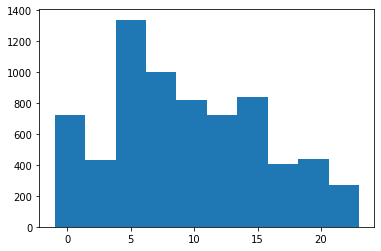

CPU times: total: 422 ms
Wall time: 424 ms


In [38]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [39]:
cluster_size_median = np.median([list(dbscan_cluster.labels_).count(c) for c in range(0, dbscan_cluster.labels_.max() + 1)])
cluster_size_std = np.std([list(dbscan_cluster.labels_).count(c) for c in range(0, dbscan_cluster.labels_.max() + 1)])
print('cluster size median: ', cluster_size_median)
print('cluster size standard deviation: ', cluster_size_std) 
print('ratio: cluster size standard deviation / cluster size median: ', cluster_size_median / cluster_size_std)

cluster size median:  270.5
cluster size standard deviation:  171.5987729818861
ratio: cluster size standard deviation / cluster size median:  1.5763515979718217


In [40]:
# Compute Cluster Quality using Silhouette Score
try:
    sc = silhouette_score(
        X=distance_matrix, 
        labels=dbscan_cluster.labels_, 
        metric="precomputed")
    print('Silhouette score: {}'.format(sc))
except:
    print('Silhouette score cannot be computed.')

Silhouette score: 0.3489067256450653


In [41]:
def get_cluster_sizes(dbscan_cluster, output='absolute')->list:
    """count absolute or relative cluster sizes given the fitted DBSCAN object. The output are absolute numbers or relative numbers referenced to the total number of datarows."""
    if output == 'absolute':
        cluster_sizes = cluster_sizes = [list(dbscan_cluster.labels_).count(c) for c in range(0, dbscan_cluster.labels_.max() + 1)]
    elif output == 'relative':
        cluster_sizes = [list(dbscan_cluster.labels_).count(c) / num_samples for c in range(0, dbscan_cluster.labels_.max() + 1)]
    else:
        print('chose the correct type of output, either absolute or relative.')
    return cluster_sizes 

In [42]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.01, 0.2, .02)
min_sample_range = np.arange(5, 50, 5)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        
        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))

        if num_cluster_detected >= 2:
            # calculate cluster quality using the silhouette score
            cluster_quality = silhouette_score(
                X=distance_matrix, 
                labels=dbscan_cluster.labels_, 
                metric="precomputed")

            # calculate cluster size median and cluster size standard deviation and the ratio of latter and last
            cluster_size_median = np.median(get_cluster_sizes(dbscan_cluster, output='absolute'))
            cluster_size_std = np.std(get_cluster_sizes(dbscan_cluster, output='absolute'))
        else:
            cluster_quality = -1 # the silhouette score is not defined for one single cluster; let´s put the quality then to -1
            cluster_size_median = -1
            cluster_size_std = -1
        # save results
        results_list.append([eps, min_samples, cluster_quality, cluster_size_median, cluster_size_std, num_cluster_detected, num_noise_data])

CPU times: total: 38.3 s
Wall time: 38.3 s


In [43]:
# turn list into dataframe
clustering_results_df = pd.DataFrame(
    data = results_list, 
    columns = (
        "eps", 
        "min_samples", 
        "silhouette score", 
        "cluster_size_median", 
        "cluster_size_std", 
        "num_clusters", 
        "num_noise_data"))

clustering_results_df.head()

,eps,min_samples,silhouette score,cluster_size_median,cluster_size_std,num_clusters,num_noise_data
0,0.01,5,-1.0,-1.0,-1.0,0,7000
1,0.01,10,-1.0,-1.0,-1.0,0,7000
2,0.01,15,-1.0,-1.0,-1.0,0,7000
3,0.01,20,-1.0,-1.0,-1.0,0,7000
4,0.01,25,-1.0,-1.0,-1.0,0,7000


In [44]:
# feature engineering: add ratio cluster_size_std / cluster_size_mean
clustering_results_df['ratio_std_median'] = clustering_results_df['cluster_size_std'] / clustering_results_df['cluster_size_median']

clustering_results_df.head()

,eps,min_samples,silhouette score,cluster_size_median,cluster_size_std,num_clusters,num_noise_data,ratio_std_median
0,0.01,5,-1.0,-1.0,-1.0,0,7000,1.0
1,0.01,10,-1.0,-1.0,-1.0,0,7000,1.0
2,0.01,15,-1.0,-1.0,-1.0,0,7000,1.0
3,0.01,20,-1.0,-1.0,-1.0,0,7000,1.0
4,0.01,25,-1.0,-1.0,-1.0,0,7000,1.0


In [45]:
clustering_results_df.groupby(by='num_clusters').median()

,eps,min_samples,silhouette score,cluster_size_median,cluster_size_std,num_noise_data,ratio_std_median
num_clusters,,,,,,,
0,0.01,30.0,-1.000000,-1.00,-1.000000,7000.0,1.000000
1,0.16,25.0,-1.000000,-1.00,-1.000000,0.0,1.000000
2,0.11,20.0,0.060849,3483.00,3360.000000,34.0,0.964460
3,0.08,30.0,-0.114616,101.50,1610.524182,3378.0,13.554624
4,0.11,42.5,-0.039722,110.50,2732.906515,317.5,24.736304
5,0.11,35.0,-0.070753,116.00,2594.235147,120.0,22.364096
6,0.05,25.0,-0.313217,94.00,69.918206,6344.0,0.743811
7,0.03,10.0,-0.392254,10.00,6.272714,6900.0,0.627271
10,0.07,45.0,-0.201542,212.00,93.112620,5148.0,0.439210


Text(0, 0.5, 'silhouette score')

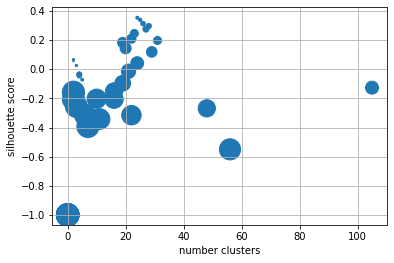

In [46]:
x = clustering_results_df['num_clusters'].values
y = clustering_results_df['silhouette score'].values
s = clustering_results_df['num_noise_data'].values

plt.scatter(
    x,
    y,
    s = 500*s/s.max())
plt.grid()
#plt.xlim(0,25)
plt.xlabel('number clusters')
plt.ylabel('silhouette score')

invalid value encountered in sqrt


Text(0, 0.5, 'silhouette score')

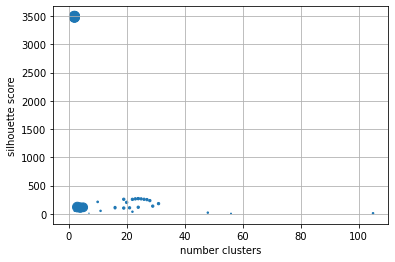

In [47]:
x = clustering_results_df['num_clusters'].values
y = clustering_results_df['cluster_size_median'].values
s = clustering_results_df['cluster_size_std'].values

plt.scatter(
    x,
    y,
    s = 100*s/s.max())
plt.grid()
#plt.xlim(0,25)
plt.xlabel('number clusters')
plt.ylabel('silhouette score')

In [48]:
nclusters = 19
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="silhouette score", ascending=False)
db_config 

,eps,min_samples,silhouette score,cluster_size_median,cluster_size_std,num_clusters,num_noise_data,ratio_std_median
43,0.09,40,0.184226,258.0,187.987490,19,1482,0.728634
32,0.07,30,-0.095265,103.0,189.266802,19,3501,1.837542


0.09 40


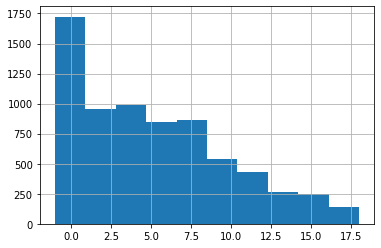

0.07 30


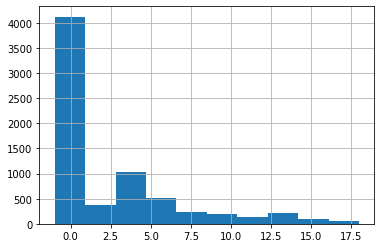

In [49]:
for conf in np.array(db_config[['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    #plt.yscale('log')
    plt.grid()
    plt.show()

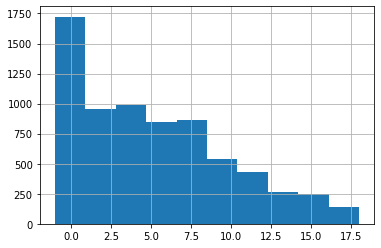

In [50]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.09, 
                        min_samples=40, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.yscale('log')
plt.grid()
plt.show()

In [51]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member,cluster
customer_id,,,,,,,,,,,
15638003,648.0,55.0,1.0,81370.07,1.0,181534.04,Spain,Male,no,yes,-1
15808971,693.0,57.0,9.0,0.00,2.0,135502.77,Spain,Female,yes,yes,0
15800482,586.0,33.0,7.0,0.00,2.0,168261.40,Spain,Female,yes,yes,0
15746726,438.0,31.0,8.0,78398.69,1.0,44937.01,Germany,Male,yes,no,8
15750407,768.0,43.0,2.0,129264.05,2.0,19150.14,Germany,Female,no,no,-1


In [52]:
# find cluster soo small that we considere them as noise
cluster_size_threshold = 0.05 # cluster size threshold in percent under which clusters are reasigned to noise cluster
noise_cluster = X_train['cluster'].value_counts() < cluster_size_threshold*X_train.shape[0]
noise_cluster = noise_cluster[noise_cluster == True].index.tolist()
noise_cluster

[3, 6, 8, 11, 9, 1, 10, 0, 16, 14, 12, 13, 17, 15, 18]

In [53]:
# reasign small clusters the label -1 for noise 
X_train['cluster'] = X_train['cluster'].apply(lambda x: -1 if x in noise_cluster else x)

In [54]:
def relabel_clusters(X_train):
    """ relabel clusters starting from 0"""
    X_train_relabeled = X_train.copy()
    for n, c in enumerate(np.sort(X_train["cluster"].unique())):
        #print(n, c)
        X_train_relabeled.loc[X_train["cluster"] == c, 'cluster'] = n
    X_train['cluster'] = X_train_relabeled['cluster']
    return X_train

In [55]:
# Relabel Clusters starting from 0
X_train = relabel_clusters(X_train)

In [56]:
X_train['cluster'].unique()

array([0, 1, 2, 4, 3], dtype=int64)

# Train Model on Cluster Label

### One Hote Encode

In [57]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [58]:
enc.fit(X_train[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [59]:
X_train_hot_enc = enc.transform(X_train[categorical_columns])

In [60]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

In [61]:
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_cat_hotenc.head()

,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,
15638003,0.0,1.0,1.0,0.0,1.0
15808971,0.0,1.0,0.0,1.0,1.0
15800482,0.0,1.0,0.0,1.0,1.0
15746726,1.0,0.0,1.0,1.0,0.0
15750407,1.0,0.0,0.0,0.0,0.0


In [62]:
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15638003,648.0,55.0,1.0,81370.07,1.0,181534.04,0.0,1.0,1.0,0.0,1.0
15808971,693.0,57.0,9.0,0.00,2.0,135502.77,0.0,1.0,0.0,1.0,1.0
15800482,586.0,33.0,7.0,0.00,2.0,168261.40,0.0,1.0,0.0,1.0,1.0
15746726,438.0,31.0,8.0,78398.69,1.0,44937.01,1.0,0.0,1.0,1.0,0.0
15750407,768.0,43.0,2.0,129264.05,2.0,19150.14,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15609187,455.0,27.0,5.0,155879.09,2.0,70774.97,0.0,0.0,0.0,0.0,0.0
15767064,614.0,36.0,1.0,44054.84,1.0,73329.08,0.0,1.0,0.0,1.0,1.0
15781505,685.0,20.0,4.0,104719.94,2.0,38691.34,0.0,0.0,1.0,1.0,0.0


In [63]:
y = X_train['cluster']

In [64]:
# create a train/test split
X_train_hotenc_train, X_train_hotenc_test, y_train, y_test = train_test_split(
    X_train_hotenc, 
    y, 
    test_size=0.3, 
    random_state=123)

# Training Sklearn Random Forest b/c of Multiclass Shap Compatibility!

In [65]:
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [66]:
clf.fit(X_train_hotenc_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [67]:
# evaluate accuracy on training set
clf.score(X_train_hotenc_train, y_train)

0.996938775510204

In [68]:
# evaluate accuracy on test set
clf.score(X_train_hotenc_test, y_test)

0.9952380952380953

In [69]:
pred = clf.predict(X_train_hotenc_train)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Tuning Random Forest

In [70]:
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [71]:
model.fit(X_train_hotenc_train, y_train)


81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200)})

In [72]:
# evaluate accuracy on training set
model.score(X_train_hotenc_train, y_train)

0.9991836734693877

In [73]:
# evaluate accuracy on test set
model.score(X_train_hotenc_test, y_test)

0.9952380952380953

In [74]:
# predict
model.predict(X_train_hotenc_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
model.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [76]:
# Save the trained classifier
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

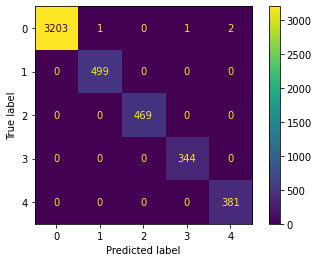

In [77]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_hotenc_train), labels=clf.classes_)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_disp.plot(values_format='d')
plt.show()

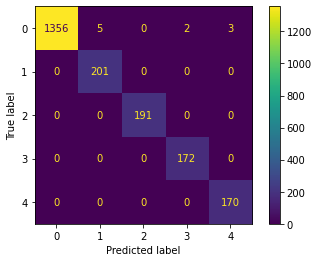

In [78]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_train_hotenc_test), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()